# Deep Convolutional Generative Adversarial Network
##### **By: Jorge Felix Martinez Pazos**
##### **From: Universidad de Ciencias Informaticas**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 1. Imports

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint

In [3]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete6FRJ5T/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete6FRJ5T/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [14]:
class_name = ['Camiseta', 'Pantalon', 'Sueter', 'Vestido', 'Abrigo',
              'Sandalia', 'Camisa', 'Tenis', 'Bolso', 'Botines']

In [4]:
ds.as_numpy_iterator().next()['label']

2

# 2. Data Vizualisation & Data Proprocessing

In [5]:
# Data Iterator
dataiterator = ds.as_numpy_iterator()

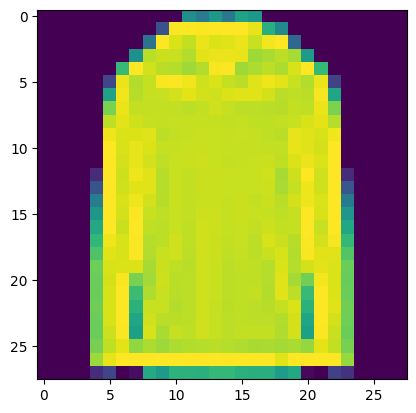

In [9]:
# Getting data out of the pipeline
plt.imshow(dataiterator.next()['image'])

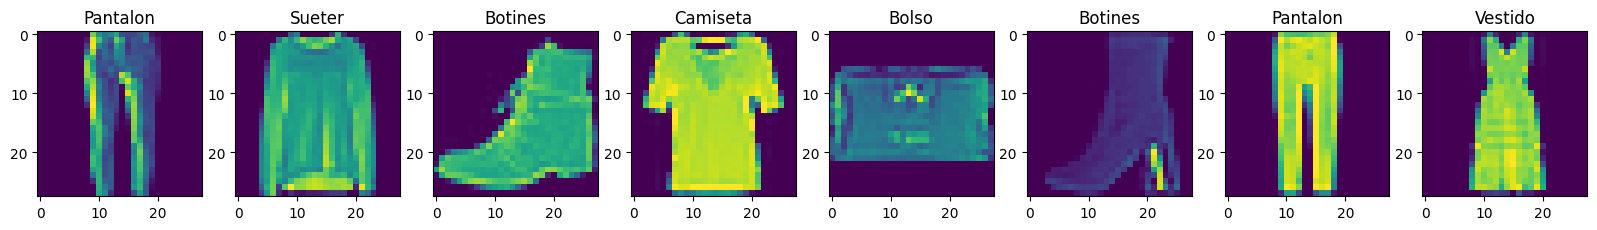

In [20]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
# Loop four times and get images 
for idx in range(8): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(class_name[sample['label']])

In [21]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [22]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images) 
ds = ds.cache() 
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [23]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. GAN Arquitecture

### 3.1 Import Modelling Components

In [24]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Model, Sequential
from keras import layers
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [25]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [26]:
generator = build_generator()

In [27]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 0s 32ms/step


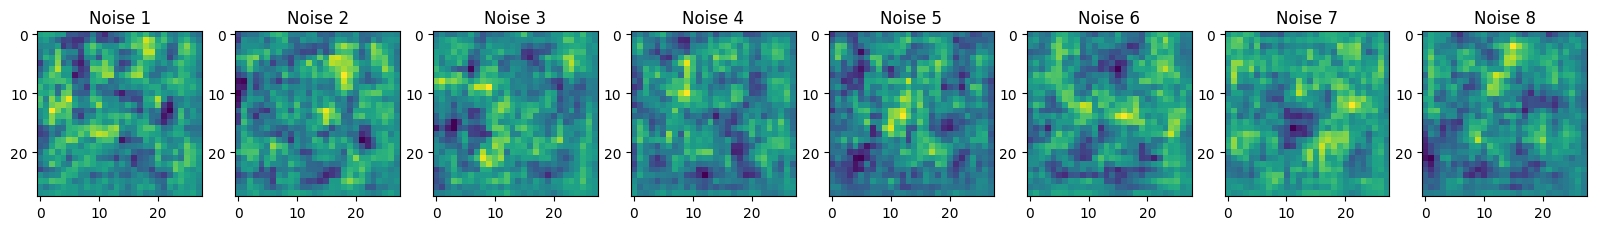

In [31]:
# Generate Noise
img = generator.predict(np.random.randn(8,128,1))
fig, ax = plt.subplots(ncols=8,figsize=(20,20))
for idx, img in enumerate(img): 
    ax[idx].imshow(img) 
    ax[idx].title.set_text(f'Noise {idx+1}')

In [32]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 294ms/step


In [33]:
img.shape

(4, 28, 28, 1)

### 3.3 Build Discriminator

In [34]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [35]:
discriminator = build_discriminator()

In [36]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [37]:
img[0].shape

(28, 28, 1)

In [38]:
discriminator.predict(img)

1/1 [==============================] - 0s 233ms/step


array([[0.5005106],
       [0.500639 ],
       [0.5005505],
       [0.500486 ]], dtype=float32)

# 4. Training Loop

### 4.1 Losses **(Binary Crossentropy)** and Optimizers **(Adam)**

In [39]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers.legacy import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [40]:
lr = 0.0001
g_opt = Adam(learning_rate=lr) 
d_opt = Adam(learning_rate=lr) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Model

In [41]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [42]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [43]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [44]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [45]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/💻AI_Projects/GAN/images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train 

In [46]:
history = fashgan.fit(ds, epochs=70, callbacks=[ModelMonitor()])

Epoch 1/70
  6/469 [..............................] - ETA: 1:19 - d_loss: 0.6856 - g_loss: 0.7042

469/469 [==============================] - 95s 189ms/step - d_loss: 0.3310 - g_loss: 2.3805
Epoch 2/70
469/469 [==============================] - 85s 182ms/step - d_loss: 0.3225 - g_loss: 2.8072
Epoch 3/70
469/469 [==============================] - 85s 181ms/step - d_loss: 0.3267 - g_loss: 2.5422
Epoch 4/70
469/469 [==============================] - 85s 181ms/step - d_loss: 0.2949 - g_loss: 2.6274
Epoch 5/70
469/469 [==============================] - 86s 183ms/step - d_loss: 0.3357 - g_loss: 1.1501
Epoch 6/70
469/469 [==============================] - 86s 183ms/step - d_loss: 0.3400 - g_loss: 2.0467
Epoch 7/70
469/469 [==============================] - 85s 181ms/step - d_loss: 0.2682 - g_loss: 2.6728
Epoch 8/70
469/469 [==============================] - 86s 183ms/step - d_loss: 0.2676 - g_loss: 2.6988
Epoch 9/70
469/469 [==============================] - 87s 185ms/step - d_loss: 0.2994 - g_loss: 1.9811
Epoch 10/70
469/469 [==============================] - 86s 183ms/step - d_loss: 0.36

In [47]:
fashgan.generator.save('/content/drive/MyDrive/💻AI_Projects/GAN/Model/generator.h5')
fashgan.discriminator.save('/content/drive/MyDrive/💻AI_Projects/GAN/Model/discriminator.h5')

In [48]:
import keras
generator = keras.models.load_model('/content/drive/MyDrive/💻AI_Projects/GAN/Model/generator.h5')

In [49]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.tail()

,d_loss,g_loss
0,0.260084,2.648141
1,0.582128,2.041028
2,0.267723,2.802724
3,0.370777,1.844878
4,0.300027,3.121543
...,...,...
65,0.672161,0.663372
66,0.689957,0.747751
67,0.683611,0.732970
68,0.681196,0.738040


### 4.4 Model Performance

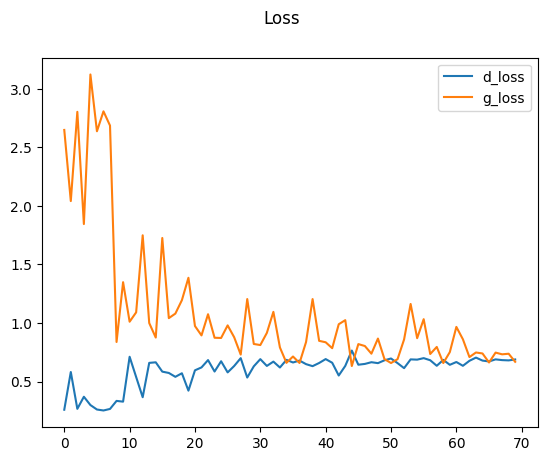

In [50]:
plt.suptitle('Loss')
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [51]:
imgs = generator.predict(tf.random.normal((25, 128, 1)))

1/1 [==============================] - 0s 446ms/step


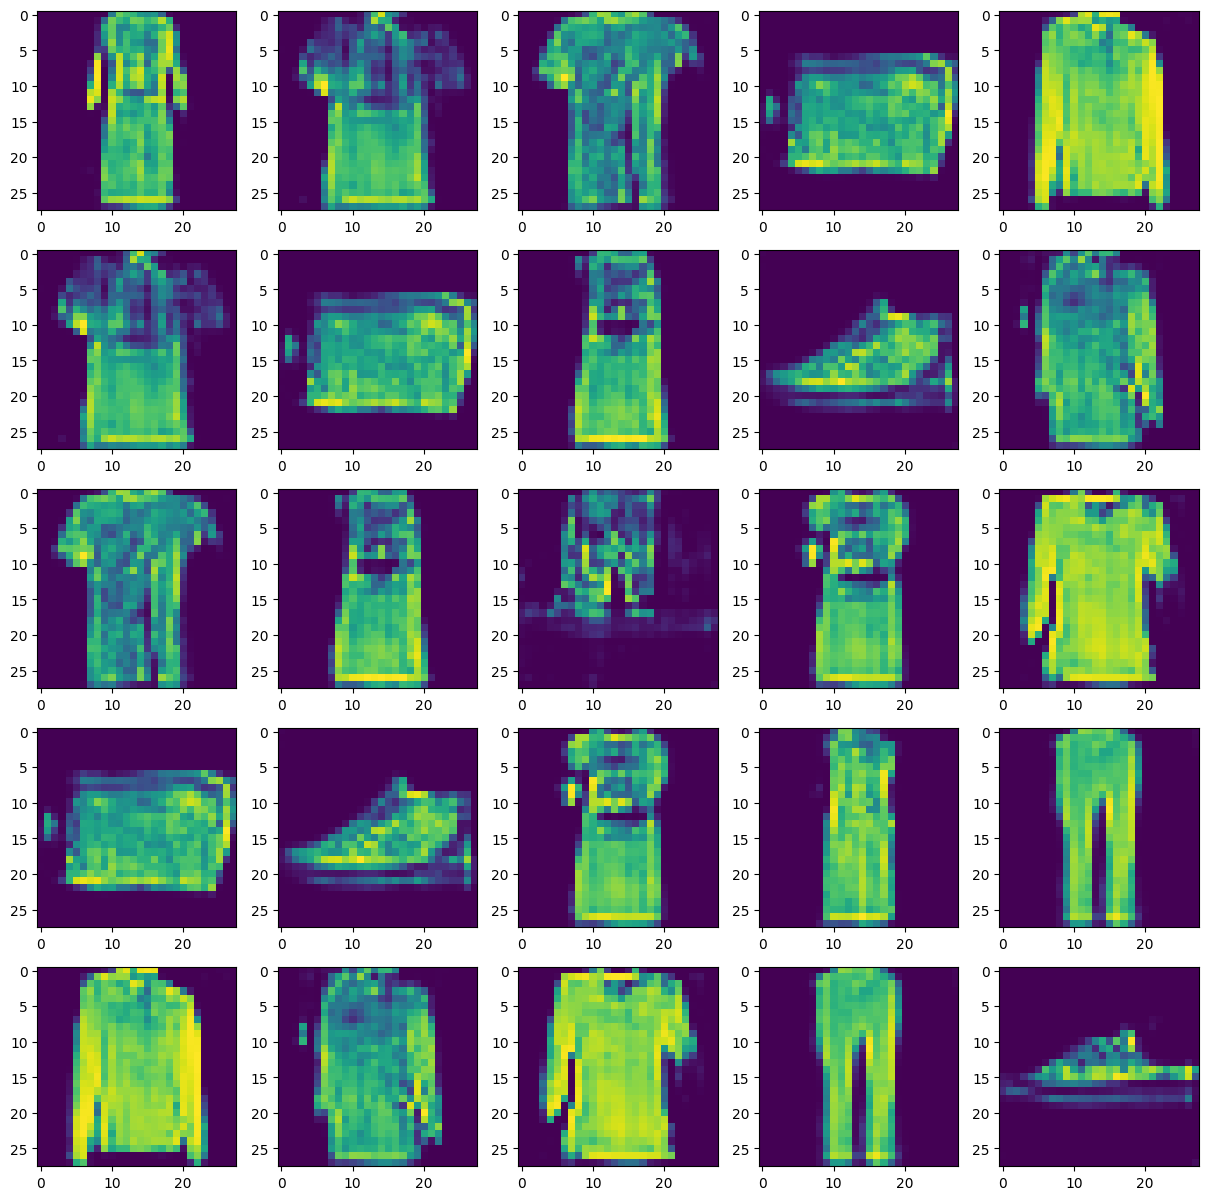

In [52]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(15,15))
for r in range(5): 
    for c in range(5): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### **With More Training Epochs (200-500) The Results Should be Better**